--------------------------------------------------------------------------RespiraGuard--------------------------------------------------------------------------


In [1]:
# Downloading the Respiratory Sound Database
from google.colab import files

# Upload the Kaggle API key file
uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Kaggle dataset path
!kaggle datasets download -d vbookshelf/respiratory-sound-database

# Unzip the downloaded file
!unzip -q respiratory-sound-database.zip -d ./dataset


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vbookshelf/respiratory-sound-database
License(s): unknown
100% 3.68G/3.69G [02:17<00:00, 28.1MB/s]
100% 3.69G/3.69G [02:17<00:00, 28.7MB/s]


In [2]:
# Load various imports
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
!pip install pydub -q

!pip install resampy -q

!pip install librosa --upgrade -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.0/260.0 kB 5.8 MB/s eta 0:00:00


In [4]:
mypath = "/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"

filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))]

p_id_in_file = [] # patient IDs corresponding to each file

for name in filenames:
    p_id_in_file.append(int(name[:3]))


In [5]:
p_id_in_file = np.array(p_id_in_file)

filepaths = [join(mypath, f) for f in filenames] # full paths of files

p_diag = pd.read_csv("/content/dataset/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [6]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data


def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)


def pitch_process(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

def extract_process(data, sample_rate):
    output_result = np.array([])

    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    output_result = np.hstack((output_result, mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40).T, axis=0)
    output_result = np.hstack((output_result, mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T, axis=0)
    output_result = np.hstack((output_result, root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    output_result = np.hstack((output_result, mel_spectogram))

    return output_result

In [7]:
def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it,
    and extracts several audio features including mean values of MFCC, Zero Crossing Rate,
    Chromagram, Root Mean Square Energy, and Mel Spectrogram from the original and its augmented versions.
    """
    try:
        # Load the original audio file
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=42, offset=0.6)

        # Extract features from the original audio data
        extracted_features = extract_process(audio, sample_rate)
        result = np.array(extracted_features)

        # Add noise and extract features
        noise_out = add_noise(audio)
        output_2 = extract_process(noise_out, sample_rate)
        result = np.vstack((result, output_2))

        # Time-stretch and then pitch-shift before extracting features
        new_out = stretch_process(audio,0.8)
        stretch_pitch = pitch_process(new_out, sample_rate,pitch_factor=0.7)
        output_3 = extract_process(stretch_pitch, sample_rate)
        result = np.vstack((result, output_3))

    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print("Error Details:", e)
        return None

    return result

In [8]:
features = []

# Iterate through each sound file and extract the features
for file_name in filepaths:

    data = extract_features(file_name)

    features.append(data)

print('Finished feature extraction from ', len(features), ' files')


/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Finished feature extraction from  920  files


In [9]:
features = np.array(features)

features.shape

(920, 3, 182)

In [10]:
# delete the very rare diseases
new_features = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

new_labels = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

##With ALL Label

In [11]:
new_labels

array(['COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'Pneumonia', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'Pneumonia', 'COPD', 'COPD', 'Healthy', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'Pneumonia', 'COPD', 'COPD',
       'COPD', 'COPD', 'Healthy', 'COPD', 'Bronchiolitis', 'COPD', 'COPD',
       'COPD', 'COPD', 'Bronchiectasis', 'COPD', 'Pneumonia', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'Pneumonia', 'COPD', 'COPD', 'COPD', 'COPD', 'URTI',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD', 'COPD',
       'COPD', 'COPD', 'COPD', 'COPD', 'Healthy', 'COPD', 'COPD', 'COPD',
       'URTI', 'COPD', 'COPD', 'COPD', 'COPD', 'Pneumonia', 'URTI',
       'Healthy', 'Bronchiolitis', 'COPD', 'COPD', 'COPD', 'Healthy',
       'COPD', 'COPD'

In [12]:
# print class counts
unique_elements, counts_elements = np.unique(new_labels, return_counts=True)

print(np.asarray((unique_elements, counts_elements)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


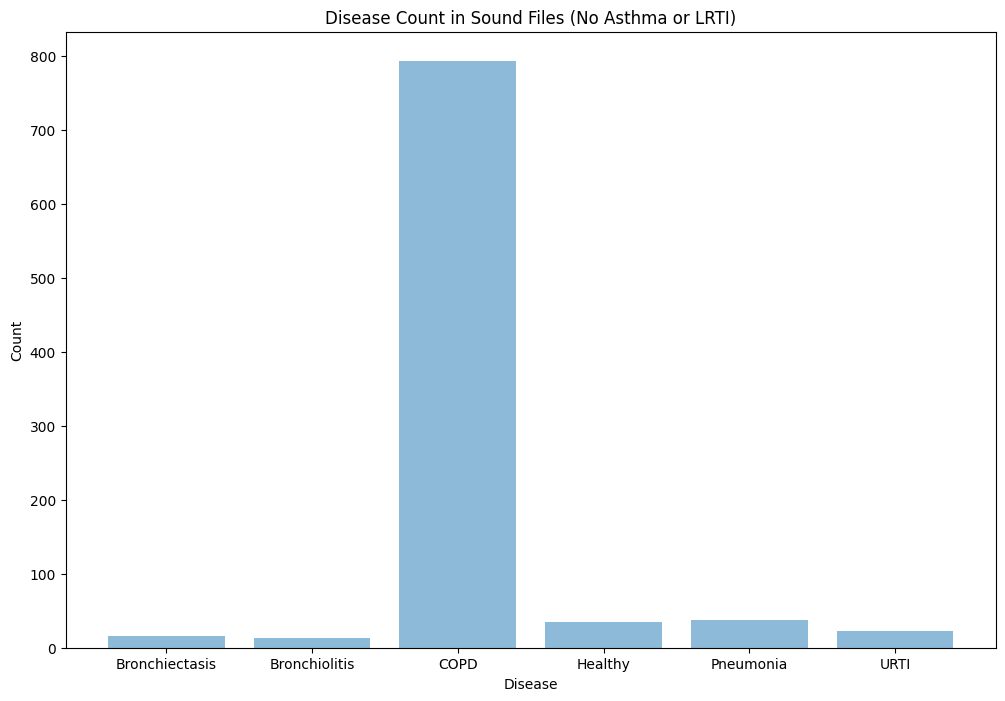

In [13]:
# plot class counts
y_pos = np.arange(len(unique_elements))

plt.figure(figsize=(12,8))

plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)

plt.xticks(y_pos, unique_elements)

plt.ylabel('Count')

plt.xlabel('Disease')

plt.title('Disease Count in Sound Files (No Asthma or LRTI)')

plt.show()

In [14]:
flattened_features = new_features.reshape(-1, 182)

augmented_labels = np.repeat(labels, 3)

augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets

In [15]:
mask = ~np.isin(augmented_labels, ['Asthma', 'LRTI'])

augmented_features = augmented_features[mask]

augmented_labels = augmented_labels[mask]

le = LabelEncoder()

i_labels = le.fit_transform(augmented_labels)

oh_labels = to_categorical(i_labels)

oh_labels.shape

(2751, 6)

In [16]:
flattened_features.shape

(2751, 182)

In [17]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, oh_labels, stratify=oh_labels,
                                                    test_size=0.2, random_state = 42)

In [18]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2200, 182)
(2200, 6)
(551, 182)
(551, 6)


In [19]:
x_train = scaler_data.fit_transform(x_train)

x_test = scaler_data.transform(x_test)

x_train = np.expand_dims(x_train,axis=2)

x_test = np.expand_dims(x_test,axis=2)

In [20]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

In [21]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

evConv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])


Epoch 1/100
35/35 [==============================] - 11s 94ms/step - loss: 0.8049 - accuracy: 0.8268 - val_loss: 0.6108 - val_accuracy: 0.8639
Epoch 2/100
35/35 [==============================] - 1s 17ms/step - loss: 0.6318 - accuracy: 0.8641 - val_loss: 0.5590 - val_accuracy: 0.8639
Epoch 3/100
35/35 [==============================] - 1s 15ms/step - loss: 0.5872 - accuracy: 0.8636 - val_loss: 0.5333 - val_accuracy: 0.8639
Epoch 4/100
35/35 [==============================] - 1s 16ms/step - loss: 0.5289 - accuracy: 0.8650 - val_loss: 0.4580 - val_accuracy: 0.8639
Epoch 5/100
35/35 [==============================] - 1s 17ms/step - loss: 0.4867 - accuracy: 0.8650 - val_loss: 0.4343 - val_accuracy: 0.8639
Epoch 6/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4661 - accuracy: 0.8623 - val_loss: 0.4732 - val_accuracy: 0.8639
Epoch 7/100
35/35 [==============================] - 1s 19ms/step - loss: 0.4245 - accuracy: 0.8682 - val_loss: 0.4565 - val_accuracy: 0.8639
Epoch

In [22]:
Model_Results = Model.evaluate(x_test,y_test)

print("LOSS:  " + "%.4f" % Model_Results[0])

print("ACCURACY:  " + "%.4f" % Model_Results[1])

18/18 [==============================] - 0s 16ms/step - loss: 0.2532 - accuracy: 0.9383
LOSS:  0.2532
ACCURACY:  0.9383


In [23]:
# Save the model
Model.save("RespiraGuard_CoughAnalysis.keras")

Text(0.5, 1.0, 'Training and Validation Loss')

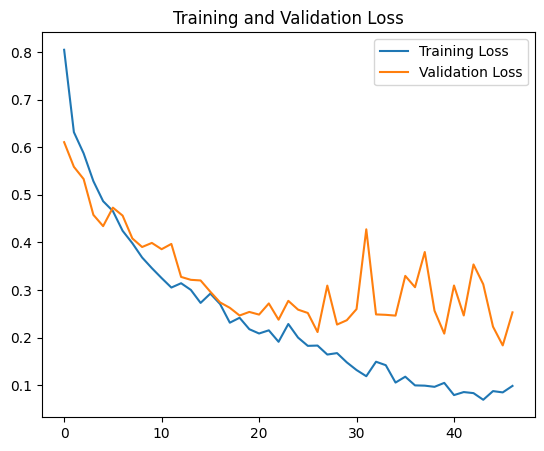

In [24]:
# Plotting loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)

plt.plot(evConv1D_Model.history['loss'], label='Training Loss')

plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')

plt.legend()

plt.title('Training and Validation Loss')

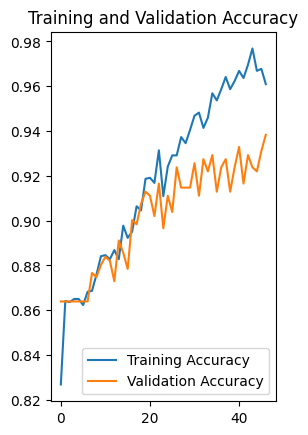

In [25]:
# Plotting accuracy
plt.subplot(1, 2, 2)

plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')

plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')

plt.legend()

plt.title('Training and Validation Accuracy')

plt.show()

In [26]:
# Getting the predictions
y_pred = Model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

18/18 [==============================] - 0s 2ms/step


In [27]:
# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

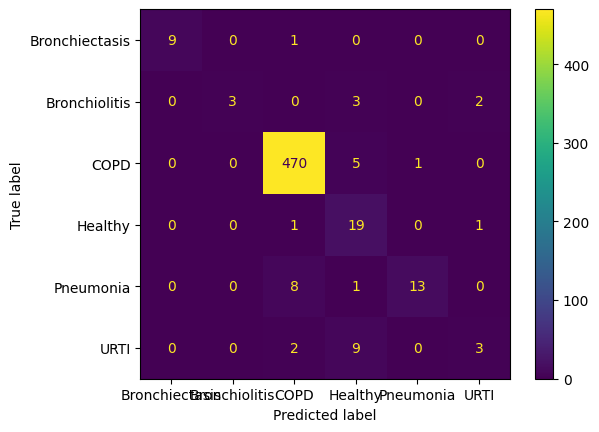

In [28]:
# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()

In [29]:
!pip3 install typing_extensions -q

In [30]:
!pip install gradio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 96.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 8.7 MB/s

In [31]:
#@title Interface
import gradio as gr
import numpy as np
from pydub import AudioSegment
from tensorflow.keras.models import load_model

# Load the saved CNN model
cnn_model = load_model("RespiraGuard_CoughAnalysis.keras")

def classify_audio(audio_file):
    # Load and preprocess the input audio file

    data = extract_features(file_name)

    Audio = scaler_data.fit_transform(data)

    predictions = cnn_model.predict(Audio)

    class_index = np.argmax(predictions)
    class_label = le.classes_[class_index]

    return class_label

# Create the Gradio interface
iface = gr.Interface(fn=classify_audio, inputs="audio", outputs="text", live=True)

# Launch the Gradio interface
iface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://f8e49e0b857054d5f7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://f8e49e0b857054d5f7.gradio.live


##Unhealthy/Healthy

In [32]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [33]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

c = 0
for i in range(len(labels)):
  if labels[i].lower() == "healthy":
    labels[i] = 1
    print(labels[i])
    c = c + 1
  else:
     labels[i] = 0
     #print(labels[i] + "na")

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [34]:
flattened_features = features.reshape(-1, 182)

augmented_labels = np.repeat(labels, 3)

augmented_features = np.reshape(features, (-1, 182))  # Flatten the feature sets

In [35]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(flattened_features, labels, stratify=labels,
                                                    test_size=0.2, random_state = 42)

ValueError: Found input variables with inconsistent numbers of samples: [2760, 920]

In [ ]:
#SCALER & TRANSFORMATION
scaler_data = StandardScaler()

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
x_train = scaler_data.fit_transform(x_train)

x_test = scaler_data.transform(x_test)

x_train = np.expand_dims(x_train,axis=2)

x_test = np.expand_dims(x_test,axis=2)

In [ ]:
from tensorflow.keras import layers, Sequential

num_labels = len(np.unique(new_labels))  # Determine the number of unique classes

Model = Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),

    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),

    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=num_labels, activation='softmax')
])

In [ ]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

early_stop = tensorflow.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

evConv1D_Model = Model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stop])


In [ ]:
Model_Results = Model.evaluate(x_test,y_test)

print("LOSS:  " + "%.4f" % Model_Results[0])

print("ACCURACY:  " + "%.4f" % Model_Results[1])

In [ ]:
# Save the model
Model.save("RespiraGuard_CoughAnalysis.keras")

In [ ]:
# Plotting loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)

plt.plot(evConv1D_Model.history['loss'], label='Training Loss')

plt.plot(evConv1D_Model.history['val_loss'], label='Validation Loss')

plt.legend()

plt.title('Training and Validation Loss')

In [ ]:
# Plotting accuracy
plt.subplot(1, 2, 2)

plt.plot(evConv1D_Model.history['accuracy'], label='Training Accuracy')

plt.plot(evConv1D_Model.history['val_accuracy'], label='Validation Accuracy')

plt.legend()

plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Getting the predictions
y_pred = Model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = np.argmax(y_test, axis=1)

In [ ]:
# Generating the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

In [ ]:
# Displaying the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_mtx, display_labels=le.classes_).plot()